# Burgers' equation physics-informed neural network (PINN)

## Problem overview

We solve Burgers' equation:


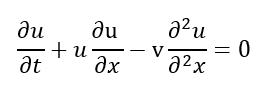


with initial conditions:

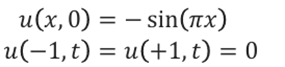

### Initial condition:

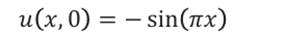


1st term of boundary loss:

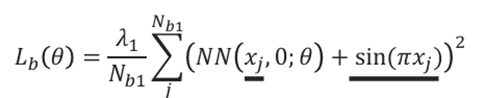

### Boundary condition 1:

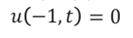


2nd term of boundary loss:

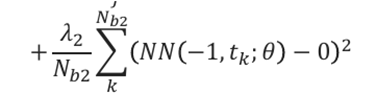

### Boundary condition 2:

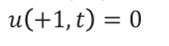


3rd term of boundary loss:

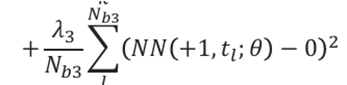

### Physics loss:


Equation:


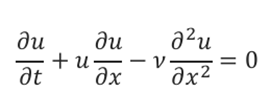


Physic loss:

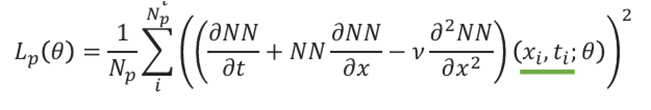


In [89]:
from PIL import Image

import numpy as np
import torch
import matplotlib.pyplot as plt

In [90]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

## Normal neural network

Next, we train a standard neural network (fully connected network) to fit these training points.

We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [91]:
def burgers_exact_solution(x, t):
    """
    Computes the exact solution of the Burgers' equation using the Cole-Hopf transformation.
    
    Parameters:
        x (torch.Tensor): Spatial domain (1D tensor).
        t (float): Time.        
    Returns:
        torch.Tensor: Exact solution of the Burgers' equation.
    """
    #  initial condition
    if torch.all(t == 0):
        return -torch.sin(np.pi * x)  # Initial condition

    # boundary conditions
    if torch.all(x == -1).item() or torch.all(x == 1).item():
        return 0
    
    # nu (float): Viscosity.
    nu = 0.01/np.pi  # Viscosity
    
    # Compute the exact solution
    phi = torch.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) + torch.exp(-(x + 4 * t)**2 / (4 * nu * (t + 1)))
    dphi_dx = -((x - 4 * t) / (2 * nu * (t + 1))) * torch.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) - \
              ((x + 4 * t) / (2 * nu * (t + 1))) * torch.exp(-(x + 4 * t)**2 / (4 * nu * (t + 1)))
    u = -2 * nu * dphi_dx / phi
    return u

In [92]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

Paramters


v = 0.01/π

----
10.000 domain/location points 

Np = 10.000


----
100 points in boundaries

Nb1 + Nb2 + Nb3 = 100

----

FCN with 9 layers, 20 hidden units (3021 free parameters)

Tanh activation function

L-BFGS optimiser

number of domain points (int) = 10000

number of boundary points = 100

In [93]:
# 10000  domain points for x between -1 and 1 and t between 0 and 1  (location points)

x = torch.linspace(-1,1,100000).view(-1,1)  
t = torch.linspace(0,1,100000).view(-1,1) 


x_data = x[torch.randperm(len(x))[:10000]]
t_data = t[torch.randperm(len(t))[:10000]]
y = burgers_exact_solution(x_data, t_data) # exact solution when t=x

# boundaries points (100 in total)
b1 = torch.linspace(-1,1,33).view(-1,1)  # 33 points for x between -1 and 1
y_b1 =  -torch.sin(np.pi * b1) # exact solution when t=0

b2 = torch.linspace(0,1,33).view(-1,1)  # 33 points for t between 0 and 1
y_b2 = np.zeros(33) # exact solution when x=-1

b3 = torch.linspace(0,1,34).view(-1,1)  # 33 points for t between 0 and 1
y_b3 = np.zeros(34) # exact solution when x=1


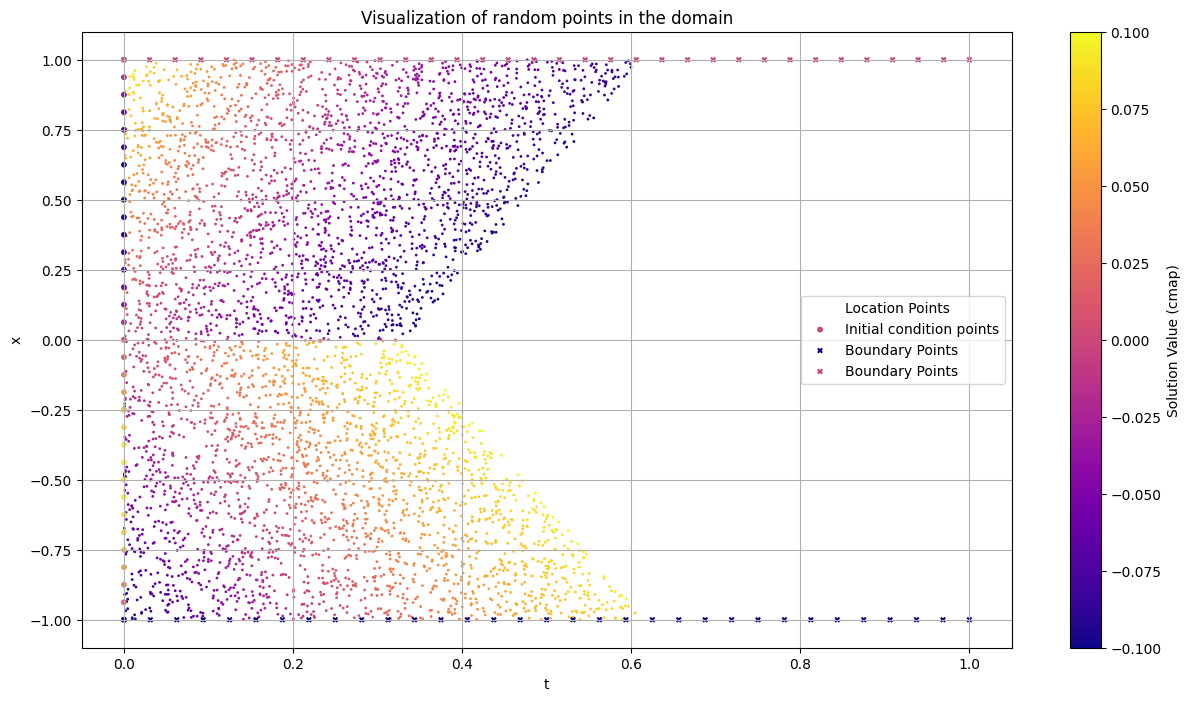

In [94]:
# Plot the 10100 points
plt.figure(figsize=(15, 8))

# Plot domain points

plt.scatter(t_data.numpy(), x_data.numpy(), s=1, c=y.numpy(), cmap='plasma', label="Location Points")

# # Plot boundary points
plt.scatter(np.zeros(33), b1.numpy(), s=10, label="Initial condition points", c=y_b1.numpy(), cmap="plasma", marker='o')
plt.scatter(b2, -np.ones(33), s=10, label="Boundary Points", c=y_b2, cmap="plasma", marker='x')
plt.scatter(b3, np.ones(34), s=10, label="Boundary Points", c=y_b3, cmap="plasma", marker='x')

# Add labels and legend
plt.title("Visualization of random points in the domain")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.colorbar(label="Solution Value (cmap)")
plt.grid(True)
plt.show()

<!--  -->


## PINN
Finally, we add the underlying differential equation ("physics loss") to the loss function.

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain 
. We can calculate the derivatives of the network solution with respect to its input variable at these points using pytorch's autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

In [95]:
import torch.nn as nn

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        super().__init__()
        activation = nn.Tanh #Activation function to use.
        self.input_layer = nn.Sequential(nn.Linear(n_input,n_hidden),activation())
        self.hidden_layers = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden,n_hidden),activation()) for _ in range(n_layers-1)])
        self.output_layer = nn.Sequential(nn.Linear(n_hidden,n_output))
        
    def forward(self, t, x):
        x = torch.cat([t, x], dim=1)
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)        
        return x

In [96]:
# train standard neural network to fit training data
torch.manual_seed(123)


model = FCN(2,1,n_hidden=20, n_layers=9)

# optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

`requires_grad = True` 

pytorch, by default, doesn't track the computation graph, for efficiency.
but we want, so we need explicitely to say, which gradients, with respect to this sensor which we do.


so we're going to do that and then we're going to just make sure that it's a nice shape for the input of the network so it so remember the network in pi to watch has a batch Dimension here

In [97]:
# define boundary points for boundary loss
# t_boundary = torch.linspace(0, 1, 100).view(-1,1)
# # boundary points for x=-1
# x_boundary1 = -torch.ones_like(t_boundary)
# # boundary points for x=1
# x_boundary2 = torch.ones_like(t_boundary)
# # boundary points for t=0
# u = torch.zeros_like(t_boundary)

# # 10000 random location points between -1 and 1
# x_location = torch.rand(10000, 1) * 2 - 1
# # 10000 random location points between 0 and 1
# t_location = torch.rand(10000, 1)

now, colocation points for the physics loss.

here we will have points for the whole domain:

In [98]:
# linspace(0,1,30) ->  This function generates a sequence of 30 evenly spaced values between 0 and 1.

# .view(-1, 1) ->  reshapes the tensor into a 2-dimensional tensor with 30 rows and 1 column.
# The -1 argument means that the number of rows is inferred from the length of the tensor, and 1 specifies the number of columns.

# .requires_grad_(True) -> gradients should be computed for this tensor during the backward pass.
#  used  in optimization problems and neural network training where you need to compute gradients for updating parameters.

# x_physics = torch.linspace(0,1,30, requires_grad=True).view(-1,1) # sample locations over the problem domain

**boundary loss 2**

`autograd` is not actually computing the jacobian.
it's computing the vector Jacobian product, when we are using reverse mode.
So we need also to define what the vector is, what we are applying to that jacobian vector product, 

`torch.ones_like(yhp)` 

` dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx`

`loss2 = torch.sqeeze((dx-0) ** 2)` 



physics loss (loss 3)



In [99]:
v = 0.01/np.pi

In [100]:
# Initial condition (t=0, x in [-1, 1])
x = torch.linspace(-1, 1, 200).reshape(-1, 1) #200 points equidistant in [-1, 1]
t = torch.zeros_like(x)                       # t=0
u = -torch.sin(torch.pi * x)                  # u(0,x)=-sin(pi*x)

# Boundary condition (x=-1, t in [0, 1])
t_boundary = torch.linspace(0, 1, 100).reshape(-1, 1)
x_bottom = -torch.ones_like(t_boundary)   # x = -1
u_bottom = torch.zeros_like(t_boundary)  # u(-1,t) = 0

# Boundary condition (x=1, t in [0, 1])
# (same t_boundary)
x_top = torch.ones_like(t_boundary)   # x = 1
u_top = torch.zeros_like(t_boundary)  # u(1,t) = 0

# Physics loss points (x in [-1, 1], t in [0, 1]) (location points)
x_physics = torch.rand(10000, 1) * 2 - 1  # random points in [-1, 1]
t_physics = torch.rand(10000, 1) * 1      # random points in [0, 1]

In [101]:
# I'm going to save all the losses, for draw them:
total_losses = []

initial_condition_losses = []
boundary_condition_losses = []
physics_losses = []



In [102]:
from IPython.display import clear_output


for i in range(10000):
    optimizer.zero_grad()
    
    lambda1, lambda2, lambda3 = 1e-1, 1e-4, 1e-4

    ##### compute the boundary loss (initial condition)    
    u_predicted = model(t, x)   
    loss_initial_condition = torch.mean((u - u_predicted) ** 2)

    
    # #### compute the boundary loss (boundary conditions)
    u_bottom_pred = model(t_boundary, x_bottom)  # bottom x=-1
    u_top_pred = model(t_boundary, x_top)        # top x=1
    loss_boundary = torch.mean((u_bottom - u_bottom_pred) ** 2) + torch.mean((u_top - u_top_pred) ** 2)    

    #  One of the differentiated Tensors does not require grad ???
    # 
    # Enable gradient tracking
    # requires_grad_ is used to enable or disable gradient tracking for a tensor.
    # It is crucial for training neural networks, allowing PyTorch to compute gradients during the backward pass.
    # It is used in scenarios where you need to update model parameters based on computed gradients.

    t_physics.requires_grad_(True) # set requires_grad to True for t_physics
    x_physics.requires_grad_(True) # set requires_grad to True for x_physics

    # #### compute the "physics loss"
    u_physics = model(t_physics, x_physics)

    du_physics_t  = torch.autograd.grad(u_physics, t_physics, torch.ones_like(u_physics), create_graph=True)[0] # computes dy/dt (first derivative of u with respect to t)
    du_physics_x  = torch.autograd.grad(u_physics, x_physics, torch.ones_like(u_physics), create_graph=True)[0]# computes dy/dx (first derivative of u with respect to x)    
    du2_physics = torch.autograd.grad(du_physics_x,  x_physics, torch.ones_like(u_physics),  create_graph=True)[0]# computes d^2y/dx^2 (second derivative of u with respect to x)
    loss_physics = torch.mean((du_physics_t + u_physics * du_physics_x - v * du2_physics)** 2) # computes the residual of differential equation (pyhsics loss)
    
    # backpropagate joint loss
    loss = lambda1 * loss_initial_condition + lambda2 * loss_boundary + lambda3 * loss_physics  # add three loss (initial, boundary and physics) terms together
    loss.backward()
    optimizer.step()
    
    # save the losses
    total_losses.append(loss.item())
    initial_condition_losses.append(loss_initial_condition.item())
    boundary_condition_losses.append(loss_boundary.item())
    physics_losses.append(loss_physics.item())

    

    # print the loss every 1000 iterations
    if (i+1) % 1000 == 0: 
        print("Iteration %i: Loss = %.3e, Initial Condition Loss = %.3e, Boundary Condition Loss = %.3e, Physics Loss = %.3e" % 
              (i+1, loss.item(), loss_initial_condition.item(), loss_boundary.item(), loss_physics.item()))
        



Iteration 1000: Loss = 6.826e-05, Initial Condition Loss = 1.053e-04, Boundary Condition Loss = 6.115e-02, Physics Loss = 5.162e-01
Iteration 2000: Loss = 4.586e-05, Initial Condition Loss = 3.405e-05, Boundary Condition Loss = 1.411e-02, Physics Loss = 4.104e-01
Iteration 3000: Loss = 4.133e-05, Initial Condition Loss = 4.545e-05, Boundary Condition Loss = 7.716e-03, Physics Loss = 3.602e-01
Iteration 4000: Loss = 3.408e-05, Initial Condition Loss = 9.771e-06, Boundary Condition Loss = 2.730e-03, Physics Loss = 3.283e-01
Iteration 5000: Loss = 3.136e-05, Initial Condition Loss = 7.488e-06, Boundary Condition Loss = 1.249e-03, Physics Loss = 3.048e-01
Iteration 6000: Loss = 2.985e-05, Initial Condition Loss = 7.559e-06, Boundary Condition Loss = 8.009e-04, Physics Loss = 2.902e-01
Iteration 7000: Loss = 2.890e-05, Initial Condition Loss = 7.851e-06, Boundary Condition Loss = 6.526e-04, Physics Loss = 2.805e-01
Iteration 8000: Loss = 2.804e-05, Initial Condition Loss = 7.309e-06, Bounda

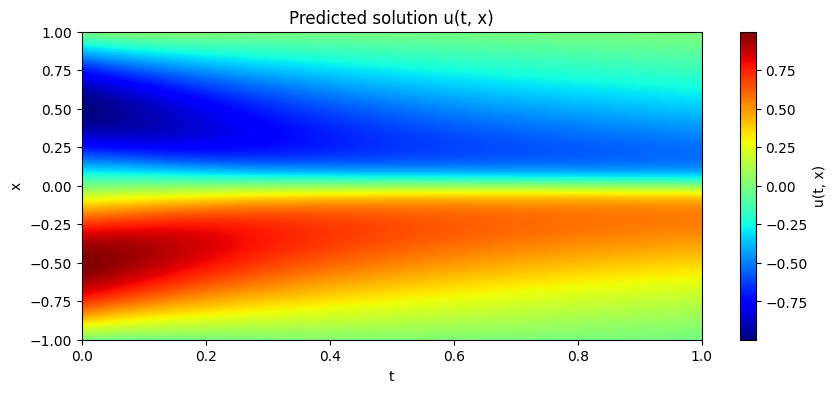

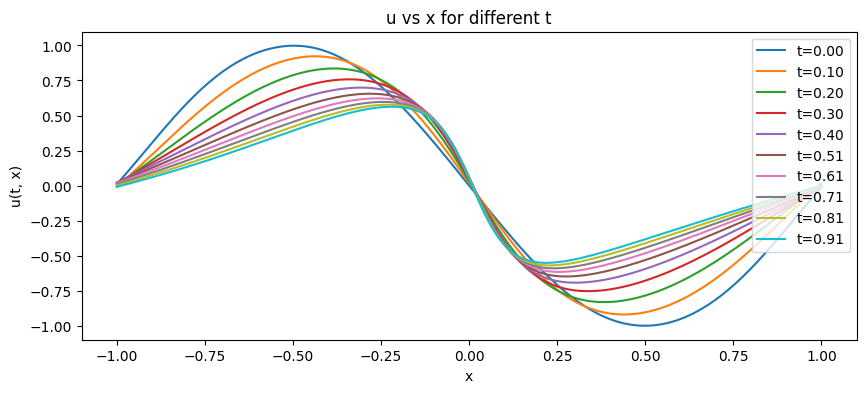

In [105]:
#Functions to have plots
#A heatmap of the predicted solution u(t, x) over the domain t ∈ [0, 1], x ∈ [-1, 1].
def plot_results(model):
    t = np.linspace(0, 1, 100)
    x = np.linspace(-1, 1, 200)
    T, X = np.meshgrid(t, x)

    t_test = torch.tensor(T.flatten().reshape(-1, 1), dtype=torch.float32)
    x_test = torch.tensor(X.flatten().reshape(-1, 1), dtype=torch.float32)
    u_pred = model(t_test, x_test).detach().numpy().reshape(200, 100)

    plt.figure(figsize=(10, 4))
    plt.imshow(u_pred, extent=[0, 1, -1, 1], origin='lower', aspect='auto', cmap='jet')
    plt.colorbar(label='u(t, x)')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('Predicted solution u(t, x)')
    plt.savefig('Burgers_predicted_sol_withbound.png')
    plt.show()
    

    # Plot u vs x for each t
    plt.figure(figsize=(10, 4))
    for i in range(100):
        if i%10 == 0:
            plt.plot(x, u_pred[:, i], label=f't={t[i]:.2f}')
    plt.xlabel('x')
    plt.ylabel('u(t, x)')
    plt.title('u vs x for different t')
    plt.legend()
    plt.savefig('Burgers_predicted_sol_ux_withbound.png')
    plt.show()

plot_results(model)

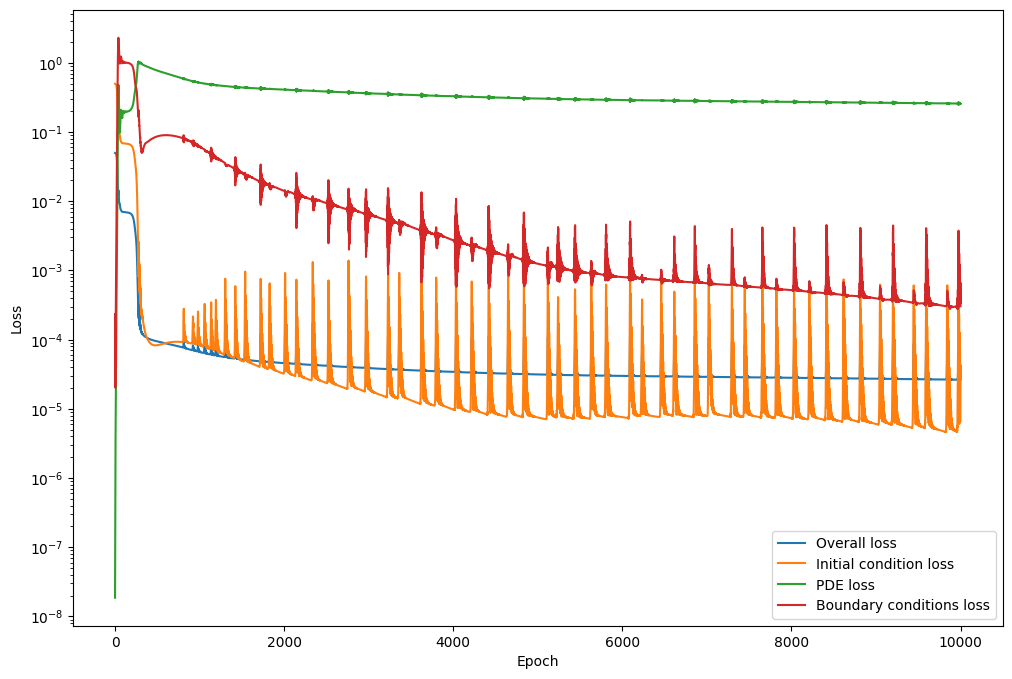

In [104]:


#A plot of the total loss over training epochs (using a logarithmic scale).
plt.figure(101, figsize=(12, 8))
plt.plot(total_losses, label="Overall loss")
plt.plot(initial_condition_losses, label="Initial condition loss")
plt.plot(physics_losses, label="PDE loss")
plt.plot(boundary_condition_losses, label="Boundary conditions loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
# plt.savefig('./data/losses_BurgersEq.png')
plt.show()